In [1]:
from utils.card_engine import Card_Game, Card_Env, random_agent

In [2]:
import math
import random
from collections import namedtuple, deque
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

from itertools import count

from tqdm import tqdm

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# Replay Memory

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        # save a transition
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Q network

In [7]:
class DQN(nn.Module):

    # n_input: the current state
    #  (1x52)    +  (56x52)       +       (1x52): the current state
    #    ^hand       ^who plays each card  ^cards not seen yet
    #                       + cards played
    # n_output: probability of playing each card
    #   (1x52)
    def __init__(self, n_input, n_output):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_input, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_output)

    def forward(self, x):
        if x.dtype == torch.float32:
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        else:
            x=x.to(torch.float32)
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        # return 13* torch.tanh(self.layer3(x))
        return self.layer3(x)

# Training

### The network agent
Selects a move according to epsilon-greedy policy:
sometimes uses the model to select move, sometimes just select one randomally

In [10]:
'''
A single step optimization of the model using Deep Q-Learning
1) samples a batch from memory, concatenates all the tensors into a single one
2) computes Q(s_t, a_t) and V(s_{t+1}) = max_a Q(s_{t+1}, a), where s_t --(a_t)--> s_{t+1}
3) computes the loss
4) updates the target network (which is computing V(s_{t+1})) at every step with soft update
'''
def optimize_model():
    transitions = []
    for turn, mem in memory.items():
        if len(mem) >= BATCH_SIZE:
            transitions += mem.sample(BATCH_SIZE)
    if transitions == []:
        return

    # transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # mask the non final states and find the corresponding next states
    # We need an illegal move to be a non-final state
    # Right now, we are throwing out all the final states which include the case when
    # the agent ends the game prematurely after playing an illegal move


    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    # print('non_final_mask is', non_final_mask)
    non_final_next_states = [s for s in batch.next_state if s is not None]

    non_final_next_states = torch.cat(non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # print('reward_batch is', reward_batch)


    # compute Q(s_t, a)
    # for each state in the batch, find the value of the corresponding action
    state_action_values = policy_net(state_batch.to(torch.float)).gather(1, action_batch)

    # compute V(s_{t+1}) = max_a Q(s_{t+1}, a) for the next_states using the target_net
    next_state_values = torch.zeros(len(transitions), device=device)
    # next_state_values = -10.0 * torch.ones(len(transitions), device=device)

    if non_final_next_states != []:

        with torch.no_grad():
            # print(non_final_mask.shape, target_net(non_final_next_states).max(1).values)
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values  # these will all be negative!

    # R + \gamma max_a Q(s', a)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # compute the Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # back propagate
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [11]:


# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
if torch.cuda.is_available():
    print("CUDA is available. GPU can be used.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available. GPU can be used.
Device name: NVIDIA GeForce GTX 1650


In [49]:
def move_to_card(move):
    return ['2','3','4','5','6','7','8','9','10','J','Q','K','A'][move % 13], ['C', 'D', 'H', 'S'][int(move / 13)]

def simulate_game(policy, verbose=False, from_move=0):
    with torch.no_grad():
        moves_played = 0
        active_player = from_move % 4
        if verbose:
            print(f"Starting new game as player {active_player} from turn {from_move}.")
        test_game = Card_Game()
        for turn in range(52):
            if test_game.current_player != active_player or turn < from_move:
                move = test_game.sample_legal_move()
            else:
                # print(policy_net(test_game.get_network_input().to(device)))
                moves_played += 1
                legal_moves = F.one_hot(env.game.get_legal_moves().to(device)).sum(0)
                moves = policy_net(env.game.get_network_input().to(device)) * legal_moves
                moves[(moves == 0).nonzero()] = -100
                move = moves.argmax().item()
                # if not(move in test_game.get_legal_moves()):
                #     if verbose:
                #         print(f"Tried to play illegal move {move_to_card(move)}")
                #     return moves_played, test_game.tricks_won[active_player]
            if verbose:
                print(f"Player {test_game.current_player} plays {move_to_card(move)}")
            test_game.play_card(move)
            if turn % 4 == 3 and verbose:
                print()
        return moves_played+1, test_game.tricks_won[active_player]

In [51]:
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000

BATCH_SIZE = 100
MEMORY_SIZE = 10000

# Learning rate of the optimizer
LR = 1e-4

# soft update rate
TAU = 0.005

# future discount
GAMMA = 0.3


n_input = 3016
n_actions = 52


# foreign_policy = DQN(n_input, n_actions).to(device)
# foreign_policy.load_state_dict(torch.load('weights/ev_trick_taking_q_function.pth'))

# env = Card_Env(foreign_policy=foreign_policy)
env = Card_Env()

policy_net = DQN(n_input, n_actions).to(device)
# use a target network to prevent oscillation or divergence
target_net = DQN(n_input, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())



optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = {turn: ReplayMemory(MEMORY_SIZE) for turn in range(13)}

steps_done = 0


In [53]:
'''
Given the game state, select an action by the epsilon-greedy policy
'''
def select_action(game):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # epsilon-greedy choice

    if sample > eps_threshold:
        with torch.no_grad():
            # return the index of the card with highest probability
            # predicted from the policy net
            # print(policy_net(game.get_network_input().to(torch.float32).to(device)))
            legal_moves = F.one_hot(env.game.get_legal_moves().to(device)).sum(0)
            moves = policy_net(env.game.get_network_input().to(device)) * legal_moves
            moves[(moves == 0).nonzero()] = -100
            return moves.max(0).indices.view(1,1)
            # return policy_net(game.get_network_input().to(device)).max(0).indices.view(1,1)
    else:
        # random select a legal action
        return torch.tensor([[game.sample_legal_move()]], device=device, dtype=torch.long) #changed from long


episode_durations = []
episode_rewards = []

def plot_durations_rewards(show_result=False):
    fig, ax = plt.subplots(2, 1)

    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)

    title = 'Result' if show_result else 'Training...'
    ax[0].set_title(f'{title} Duations each Episode')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Duration')

    ax[1].set_title(f'{title} Rewards each Episode')
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('Reward')

    ax[0].plot(durations_t.numpy())
    ax[1].plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax[0].plot(means.numpy())

    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        ax[1].plot(means.numpy())

    fig.tight_layout()

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.clear_output(wait=True)
            display.display(fig)
        else:
            display.display(fig)

In [57]:
# policy_net.load_state_dict(torch.load('weights/ev_trick_taking_q_function.pth'))

# target_net = DQN(n_input, n_actions).to(device)
# target_net.load_state_dict(policy_net.state_dict())

with torch.no_grad():
    legal_moves = F.one_hot(env.game.get_legal_moves().to(device), num_classes=52).sum(0)
    print(policy_net(env.game.get_network_input().to(device)) * legal_moves)
    print(target_net(env.game.get_network_input().to(device)) * legal_moves)
    moves = policy_net(env.game.get_network_input().to(device)) * legal_moves
    moves[(moves == 0).nonzero()] = -100
    print(moves)
    # print(foreign_policy(env.game.get_network_input().to(device)))

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0334, -0.0000, -0.0000, -0.0000,
        -0.0000,  0.0000,  0.0287, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
         0.0096,  0.0150,  0.0672, -0.0631, -0.0846,  0.0000,  0.0000, -0.0000,
        -0.0000, -0.0000,  0.0140, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
         0.0000,  0.0000,  0.0211,  0.0574,  0.0000,  0.0000,  0.0000, -0.0000,
         0.0000, -0.0000, -0.0000, -0.0384, -0.0182, -0.0000,  0.0000,  0.0605,
        -0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0334, -0.0000, -0.0000, -0.0000,
        -0.0000,  0.0000,  0.0287, -0.0000, -0.0000,  0.0000, -0.0000, -0.0000,
         0.0096,  0.0150,  0.0672, -0.0631, -0.0846,  0.0000,  0.0000, -0.0000,
        -0.0000, -0.0000,  0.0140, -0.0000,  0.0000, -0.0000,  0.0000, -0.0000,
         0.0000,  0.0000,  0.0211,  0.0574,  0.0000,  0.0000,  0.0000, -0.0000,
         0.0000, -0.0000, -0.0000, -0.0384, -0.0182, -0.00

In [28]:
# fp =  DQN(n_input, 52).to(device)
# fp.load_state_dict(torch.load('latest_q_function.pth', map_location=torch.device('cpu')))

num_episodes = 30000
update_ind = 1000

save_ind = 1000

rewards_list = []
benchmark = (-13, 0)

for i_episode in count():
    # if i_episode % save_ind == 0 and i_episode != 0:
    #     torch.save(policy_net.state_dict(), f'/content/drive/MyDrive/deep-learning/dqn/q_fn-{i_episode}.pth')

    if i_episode % update_ind == 0 and i_episode != 0:
        # plot_durations_rewards()
        print(f"Trained {i_episode} episodes")
        avg_reward = sum(rewards_list) / len(rewards_list)
        print(f'Average reward per move: {avg_reward}.')
        simul_results = []
        simul_tricks = 0
        simul_dist = [0 for i in range(14)]
        for g in range(100):
            res, tricks = simulate_game(policy_net, verbose=False, from_move=random.randint(0,3))
            simul_results.append(res)
            if res != 0:
                simul_tricks += tricks / res
            simul_dist[res-1] += 1
        print(f"Average simulated game duration: {sum(simul_results) / 100}; Average tricks won per move: {round((simul_tricks / 100).item(), 4)}")
        print(f"Distribution of simulated game lengths: {simul_dist}")
        print(f"Memory bank: {[len(mem) for i, mem in memory.items()]}")
        if benchmark[0] < avg_reward and i_episode >= num_episodes:
            print("New benchmark set.")
            torch.save(policy_net.state_dict(), 'weights/ev_q_function_output.pth')
            benchmark = (avg_reward, sum(simul_results) / 100)
        rewards_list = []
        print()


    env.reset()

    player_ind = random.randint(0, 3)
    while env.game.current_player != player_ind:
        move = env.game.sample_legal_move()
        env.game.play_card(move)

    current_reward = 0
    state = torch.tensor(env.game.get_network_input(), dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        action = select_action(env.game)
        # Select action based on policy network

        # with torch.no_grad():
        #     q_values = policy_net(state)
        #     action = q_values.max(1)[1].view(1, 1)

        # Perform action in the environment
        observation, reward, terminated = env.step(action.item(),fp=None)
        rewards_list.append(reward)
        reward = torch.tensor([reward], device=device)
        done = terminated

        current_reward += reward

        # Compute next state
        if not terminated:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        else:
            next_state = None

        # Store transition in memory
        # int(env.game.turn_counter / 4)
        memory[t].push(state, action, next_state, reward)

        # Move to next state
        state = next_state

        # Perform optimization step
        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            # print(f'Episode {i_episode} ended in {t} steps.')
            episode_durations.append(t+1)
            episode_rewards.append(current_reward)
            break

# plot_durations_rewards(show_result=True)

C:\Users\evarv\Documents\Erdos\dql-trick-game\utils\card_engine.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  card = torch.nn.functional.one_hot(torch.tensor(deck_index, dtype=int), self.num_cards * self.num_players).flatten()
C:\Users\evarv\AppData\Local\Temp\ipykernel_1520\2025645416.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(env.game.get_network_input(), dtype=torch.float32, device=device).unsqueeze(0)
C:\Users\evarv\AppData\Local\Temp\ipykernel_1520\2025645416.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(s

Trained 1000 episodes
Average reward per move: 0.017052866518497467.
Average simulated game duration: 7.99; Average tricks won per move: 0.2609
Distribution of simulated game lengths: [2, 1, 6, 3, 5, 7, 8, 16, 22, 17, 10, 3, 0, 0]
Memory bank: [1000, 973, 947, 901, 861, 791, 718, 644, 527, 359, 215, 112, 62]

Trained 2000 episodes
Average reward per move: 0.01986079290509224.
Average simulated game duration: 8.51; Average tricks won per move: 0.3186
Distribution of simulated game lengths: [0, 1, 1, 1, 6, 8, 15, 14, 17, 18, 14, 5, 0, 0]
Memory bank: [2000, 1963, 1922, 1853, 1769, 1641, 1490, 1344, 1098, 740, 416, 203, 91]

Trained 3000 episodes
Average reward per move: 0.021233737468719482.
Average simulated game duration: 8.44; Average tricks won per move: 0.2735
Distribution of simulated game lengths: [2, 2, 0, 1, 3, 5, 17, 14, 26, 12, 13, 4, 1, 0]
Memory bank: [3000, 2961, 2907, 2820, 2694, 2519, 2305, 2069, 1684, 1141, 630, 289, 113]

Trained 4000 episodes
Average reward per move: 0

KeyboardInterrupt: 

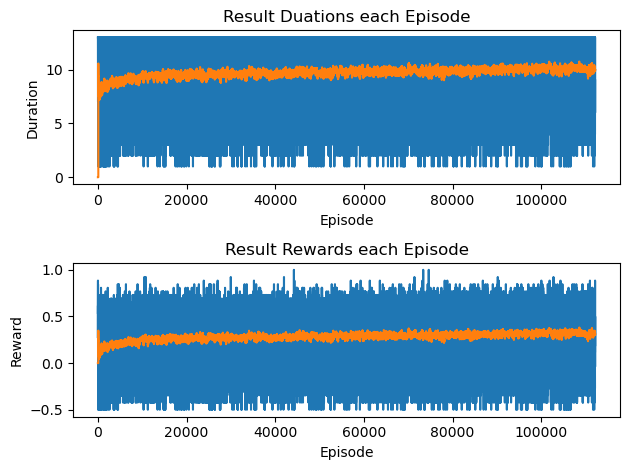

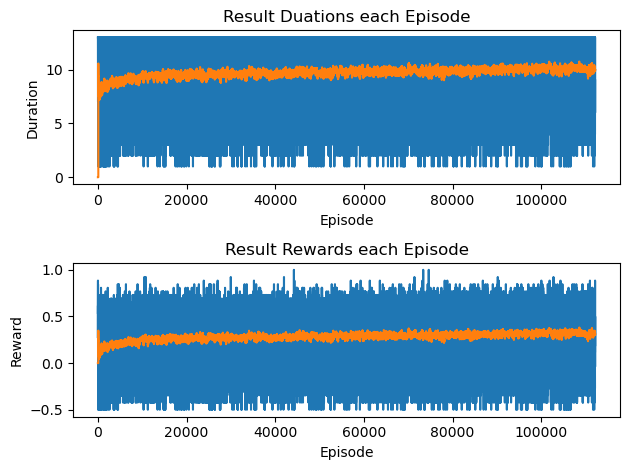

In [30]:
plot_durations_rewards(show_result=True)

In [32]:
# simulate_game(policy_net, verbose=True, from_move=random.randint(0,3))
test = DQN(n_input, n_actions).to(device)
# test.load_state_dict(torch.load('weights/ev_q_function_output.pth'))
test.load_state_dict(torch.load('weights/ev_working_function.pth'))
simul_test = []
simul_policy = []
sum_tricks_policy = 0
sum_tricks_test = 0
with torch.no_grad():
    test_dist = [0 for i in range(14)]
    policy_dist = [0 for i in range(14)]
    for g in range(10000):
        res_policy = simulate_game(policy_net, verbose=False, from_move=random.randint(0,3))
        res_test = simulate_game(test, verbose=False, from_move=random.randint(0,3))
        simul_test.append(res_test[0])
        simul_policy.append(res_policy[0])
        test_dist[res_test[0]-1] += 1
        policy_dist[res_policy[0]-1] += 1
        sum_tricks_policy += res_policy[1]
        sum_tricks_test += res_test[1]
    print(f"Average simulated game duration of test: {sum(simul_test) / 10000}. Average tricks taken: {round((sum_tricks_test / 10000).item(), 4)}")
    print(f"Average simulated game duration of policy: {sum(simul_policy) / 10000}. Average tricks taken: {round((sum_tricks_policy / 10000).item(), 4)}")
    print()
    print(f"Distribution of game lengths of test: {test_dist}")
    print(f"Distribution of game lengths of policy: {policy_dist}")


C:\Users\evarv\Documents\Erdos\dql-trick-game\utils\card_engine.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  card = torch.nn.functional.one_hot(torch.tensor(deck_index, dtype=int), self.num_cards * self.num_players).flatten()


Average simulated game duration of test: 9.8251. Average tricks taken: 3.1382
Average simulated game duration of policy: 9.8366. Average tricks taken: 3.1371

Distribution of game lengths of test: [11, 42, 61, 142, 169, 386, 551, 860, 1443, 2215, 1888, 1487, 672, 73]
Distribution of game lengths of policy: [12, 35, 77, 118, 178, 354, 583, 874, 1441, 2133, 1980, 1461, 673, 81]


In [34]:
with torch.no_grad():
    env.game.reset()
    net_input = env.game.get_network_input().to(device)
    hand = net_input[:52]
    cards = torch.arange(52).to(device)
    q_func_policy = policy_net(net_input)
    q_func_test = test(net_input)
    print(f'{q_func_policy.argmax()}')
    print(torch.stack((cards, hand, q_func_policy, q_func_test)).transpose(0, 1))

10
tensor([[ 0.0000e+00,  0.0000e+00, -8.9286e-01, -3.9408e+00],
        [ 1.0000e+00,  1.0000e+00,  4.5305e-02,  5.6045e-01],
        [ 2.0000e+00,  0.0000e+00, -1.9064e+00, -3.8085e+00],
        [ 3.0000e+00,  1.0000e+00,  4.6553e-01, -4.5756e-01],
        [ 4.0000e+00,  0.0000e+00, -4.8862e-01, -3.4618e+00],
        [ 5.0000e+00,  1.0000e+00,  1.1051e+00, -4.9176e-02],
        [ 6.0000e+00,  0.0000e+00,  5.9090e-02, -4.0541e+00],
        [ 7.0000e+00,  0.0000e+00, -3.6193e-01, -4.2140e+00],
        [ 8.0000e+00,  0.0000e+00, -4.5684e-01, -3.7149e+00],
        [ 9.0000e+00,  0.0000e+00,  2.8276e-01, -4.2098e+00],
        [ 1.0000e+01,  1.0000e+00,  1.2814e+00,  7.1092e-01],
        [ 1.1000e+01,  0.0000e+00,  1.2201e-01, -3.9811e+00],
        [ 1.2000e+01,  0.0000e+00,  2.6527e-01, -4.1150e+00],
        [ 1.3000e+01,  0.0000e+00, -8.0006e-01, -3.7074e+00],
        [ 1.4000e+01,  1.0000e+00,  5.5960e-01, -1.7970e-01],
        [ 1.5000e+01,  0.0000e+00, -3.6927e-01, -4.3123e+00],
     

In [78]:
def save_memory(memory_file):
    with open(memory_file, 'wb') as outp:
        pickle.dump(memory, outp, pickle.HIGHEST_PROTOCOL)

save_memory('saved_memory_data.pkl')

In [80]:
def load_memory(memory_file):
    with open(memory_file, 'rb') as inp:
        return = pickle.load(inp)

memory = load_memory('saved_memory_data.pkl')

KeyboardInterrupt: 

In [ ]:
torch.save(policy_net.state_dict(), 'ev_q_function_output.pth')

In [34]:
simulate_game(policy_net, verbose=True, from_move=random.randint(0, 3))

Starting new game as player 0 from turn 0.
Player 0 plays ('A', 'D')
Player 1 plays ('Q', 'D')
Player 2 plays ('7', 'D')
Player 3 plays ('9', 'D')

Player 0 plays ('K', 'C')
Player 1 plays ('A', 'C')
Player 2 plays ('6', 'C')
Player 3 plays ('4', 'C')

Player 1 plays ('3', 'H')
Player 2 plays ('8', 'H')
Player 3 plays ('10', 'H')
Player 0 plays ('K', 'H')

Player 3 plays ('Q', 'H')
Player 0 plays ('Q', 'S')
Player 1 plays ('9', 'H')
Player 2 plays ('J', 'H')

Player 0 plays ('6', 'S')
Player 1 plays ('5', 'S')
Player 2 plays ('10', 'S')
Player 3 plays ('2', 'H')

Player 2 plays ('A', 'H')
Player 3 plays ('5', 'H')
Player 0 plays ('4', 'S')
Player 1 plays ('7', 'H')

Player 0 plays ('5', 'C')
Player 1 plays ('10', 'C')
Player 2 plays ('J', 'C')
Player 3 plays ('9', 'C')

Player 2 plays ('8', 'D')
Player 3 plays ('5', 'D')
Player 0 plays ('3', 'C')
Player 1 plays ('3', 'S')

Player 2 plays ('10', 'D')
Player 3 plays ('2', 'D')
Player 0 plays ('7', 'C')
Player 1 plays ('6', 'H')

Player 2

(10, tensor(3))

In [54]:
test_game = Card_Game()

def play_up_to_move(policy, verbose=False, from_move=0):
    with torch.no_grad():
        moves_played = 0
        active_player = from_move % 4
        if verbose:
            print(f"Starting new game as player {active_player} from turn {from_move}.")
        test_game = Card_Game()
        for turn in range(52):
            if test_game.current_player != active_player or turn < from_move:
                move = test_game.sample_legal_move()
            else:
                # print(policy_net(test_game.get_network_input().to(device)))
                moves_played += 1
                move = policy_net(test_game.get_network_input().to(device))
                # if verbose:
                #     print(move)
                move = move.argmax().item()
                if test_game.hands[active_player][move] == 0:
                    if verbose:
                        print(f"Tried to play {move_to_card(move)}, which was not in the hand!")
                if not(move in test_game.get_legal_moves()):
                    if verbose:
                        print(f"Tried to play illegal move {move_to_card(move)}")
                    return moves_played, test_game.tricks_won[active_player]
            if verbose:
                print(f"Player {test_game.current_player} plays {move_to_card(move)}")
            test_game.play_card(move)
            if turn % 4 == 3 and verbose:
                print()
        return moves_played+1, test_game.tricks_won[active_player]

In [78]:
play_up_to_move(policy_net, verbose=True)

Starting new game as player 0 from turn 0.
Player 0 plays ('K', 'S')
Player 1 plays ('A', 'S')
Player 2 plays ('8', 'S')
Player 3 plays ('9', 'D')

Player 1 plays ('J', 'C')
Player 2 plays ('8', 'C')
Player 3 plays ('5', 'C')
Player 0 plays ('10', 'C')

Player 1 plays ('4', 'H')
Player 2 plays ('5', 'H')
Player 3 plays ('A', 'H')
Player 0 plays ('3', 'H')

Player 3 plays ('9', 'C')
Player 0 plays ('Q', 'S')
Player 1 plays ('6', 'C')
Player 2 plays ('Q', 'C')

Player 0 plays ('K', 'D')
Player 1 plays ('6', 'D')
Player 2 plays ('A', 'D')
Player 3 plays ('5', 'D')

Player 2 plays ('2', 'D')
Player 3 plays ('8', 'D')
Player 0 plays ('4', 'D')
Player 1 plays ('3', 'D')

Player 3 plays ('A', 'C')
Player 0 plays ('7', 'H')
Player 1 plays ('3', 'C')
Player 2 plays ('7', 'C')

Player 3 plays ('9', 'H')
Player 0 plays ('8', 'H')
Player 1 plays ('6', 'H')
Player 2 plays ('J', 'H')

Player 3 plays ('Q', 'H')
Tried to play illegal move ('4', 'S')


(9, tensor(1))

In [46]:
policy_net(test_game.get_network_input().to(device))

tensor([-0.0928, -0.1030, -0.0908,  0.0637, -0.0890, -0.1186, -0.0986, -0.1284,
        -0.1057,  0.0786, -0.0975, -0.0715, -0.1013, -0.0908, -0.0620, -0.0337,
        -0.0689, -0.0903, -0.0743,  0.0734,  0.0714, -0.0987, -0.0965, -0.0701,
        -0.0916, -0.0434, -0.3201,  0.0605,  0.0593,  0.0639,  0.0019, -0.0485,
         0.0701,  0.0712, -0.1239, -0.0674,  0.0913,  0.0986, -0.0245, -0.1979,
        -0.1523, -0.1273, -0.1612,  0.0601, -0.1541, -0.1663, -0.1639,  0.0638,
        -0.1590, -0.1269, -0.1007,  0.0018], device='cuda:0',
       grad_fn=<ViewBackward0>)